# Tutorial 6

## Monte carlo Simulation of 2D Classical Ising Model on square lattice via Metropolis algorithm.

### Hamiltonian
   In this tutorial we will be studying 2D classical Ising model  , which is given by :
   
\begin{equation}
\mathcal{H} = J\sum_{i=1}^{N}\sigma^z_{i}\sigma^z_{i+1} 
\end{equation}

where $J <0 $ and $\sigma^z$ can be $\pm 1$.
---------------------------

### Metropolis algorithm :


1. **Initialization**: Start with an initial configuration of the system. This configuration can be randomly generated.
   
2. **Site Selection**: "Propose" a single spin flip at a random lattice site. (The term "propose" is often used to select where the Monte Carlo action will take place during the update. We are focusing on a single site here. E.g., another proposal could have to flip spins on a bond or some other larger group of sites.)

3. **Energy Change Calculation**: Calculate the change in energy (ΔE) that would result from flipping the spin at the proposed site.

4. **Metropolis Acceptance Criterion**: for the proposed spin flip to get accepted with detailed balance, check
   - If ΔE < 0, then accept the new configuration (flip the spin) because it lowers the energy.
   - If ΔE > 0, then accept the new configuration with a probability of exp(-ΔE / kT), else reject the proposed spin flip, where k is the Boltzmann constant (take k=1) and T is the temperature.

5. **Iteration**: Repeat steps 2-4 for a large number of iterations such that the system essentially reaches equilibrium.

This algorithm ensures that the system explores configurations with lower energy more often, in line with the principles of statistical mechanics and the Boltzmann distribution, leading to convergence towards equilibrium at the desired temperature. Equilibrium state is where observable quantities, such as magnetization or energy, have stabilized and no longer show significant changes with additional iterations.


### Implementation:

   1. Implement the Metropolis scheme. One Monte Carlo sweep (MCS) is typically defined as a series of spin flips, so that $\textbf{on an average all sites get potentially visited once}$. Here, visiting once (on average) is also our choice.
   2. Warm-up : Compute energy after each MCS till convergence is seen.
   3. After this intial period of "warm-up", then start measurement of observables.   
         
         


### Autocorrelation time :

The autocorrelation function for any observable Q is defined as :
\begin{equation}
A_{Q}(t)= \frac{\langle Q(i+t)Q(i)\rangle - \langle Q(i)\rangle^{2}}{\langle Q^{2}(i)\rangle - \langle Q(i)\rangle^{2}}
\end{equation}

where t and i denotes time in terms of monte-carlo sweeps. In terms of MCS, auto-correlation time represent duration after which the system becomes effectively statistically independent.



### Binning error analysis :

To calculate the statistical errors, let us have a simulated MC time series for some observable over a (large) number of iterations $MC_{total}$ after warm-up.
We can subdivide the time series into $B$ bins, each bin containing $M$ number of Monte Carlo sweeps with $B \times M = MC_{total}$. $M$ is thus the bin size. For observable $Q$, averages $\bar Q_{b}$, $b = 1,...,B$ are computed over each bin, and the final bin-size or $M$ dependent average $\bar Q$ and error bar $\sigma_{Q}$ (one standard deviation of the average of the bin averages) are calculated according to


\begin{equation}
\bar Q (M) = \frac{1}{B} \sum_{b=1}^{B} \bar Q_{b} , \quad \sigma_{Q}^{2}(M) = \frac{1}{B(B-1)}\sum_{b=1}^{B}(\bar Q_{b}-\bar Q)^{2}
\end{equation}

Once the bin size $M$ becomes large enough (i.e. greater than the auto-correlation time), the error will become independent of $B$.
The final estimate of the true expectation value $\langle Q \rangle$ should then be quoted as $\bar Q \pm \sigma_{Q}$ where $\sigma_{Q}$ is the $B$-independent estimate.


To read more about the  autocorrelation time and error analysis, see page (30) of https://arxiv.org/pdf/1101.3281v1.pdf.

- Name: Siddhant Midha
- Roll no.: 200070078
- *Declaration*. I have adhered to the academic code of conduct and will do so in the future as well.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
from numpy import sqrt, pi
plt.rcParams.update({'font.size': 22 })
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
from scipy.sparse import csr_matrix
from qutip import *
import scipy
import random
from joblib import Parallel, delayed

k = 1 

# Exercise:
   1. Implement the metropolis scheme and plot the energy and magnetization ($ m = \frac{1}{N_{s}}\sum_{i}\sigma^z_{i} $ ) for all MCS including warm-up, say for L=40 at T= 1.0 and 5.0.
   2. Calculate the autocorrelation $A_{|m|}(t)$ for $|m|$ and plot it. Do this for different temperature such as T=  1.0,  2.0,  5.0 for L=40. Comment on the observation. 
   3. Show the convergence of statistical error of $|m|$ with binsize ($M$) .
   4. Plot $|m|$ vs temperature for different system size, L = 20,40,60. Estimate the critical temperature for this model.




In [2]:
def compute_energy1D(config,J=-1,bc='open'):
    # for 1D classical ising, not using
    N = np.shape(config)
    extent = N-1 if bc == 'open' else N
    rowsum = 0 
    for i in range(extent):
        site = config[i]
        nextsite = config[(i+1)%N]
        rowsum += site * nextsite 
    return (rowsum) * J

def compute_energy2D(config,J=-1,bc='open'):
    # for 2D classical ising 
    N, N = np.shape(config)
    extent = N-1 if bc == 'open' else N
    rowsum = 0 
    columnsum = 0
    for i in range(extent):
        row = config[i,:]
        nextrow = config[(i+1)%N,:]
        rowsum += np.sum(row * nextrow) # row contributions
        column = config[:,i]
        nextcolumn = config[:,(i+1)%N]
        columnsum += np.sum(column * nextcolumn) # column contributions
    return (rowsum + columnsum) * J

In [617]:
def return_mc2D(N=15,T=0.1,ITER=50000,include_warm=False,start='up'):
    INIT_TIME = 1 * N ** 2 #warm up time ~ #spins

    # check if warmup results are to be included or not 
    if include_warm == True:
        INIT_TIME = 0

    #different methods to start in
    if start == 'up':
        config = np.ones((N,N)) 
    elif start == 'down':
        config = -np.ones((N,N)) 
    elif start == 'random':
        config = np.random.choice([1,-1],size=(N,N))
    elif start == 'rowneel':
        config = np.ones((N,N))  
        for i in range(N):
            if i %2 == 0:
                config[i,:] = -1
    elif start == 'columnneel':
        config = np.ones((N,N))  
        for i in range(N):
            if i %2 == 0:
                config[:,i] = -1

    # returning arrays
    mz_arr = []
    energy_arr = []
    
    # main loop
    for idx in (range(ITER)):
        energy = compute_energy2D(config) 
        
        if idx > INIT_TIME:
            energy_arr.append(energy)
            mz = (np.sum(config)) / (N**2)
            mz_arr.append(mz)

        # choose random site coordinates
        row_ind = random.choice(range(N))
        column_ind = random.choice(range(N)) 

        newconfig = np.copy(config) 
        newconfig[row_ind,column_ind] = -config[row_ind,column_ind] # flip random site

        newenergy = compute_energy2D(newconfig)
        if newenergy < energy:  # case 1
            config = np.copy(newconfig) 
        
        elif newenergy > energy: # case 2 
            delta = - energy + newenergy
            prob = np.exp(-delta / (k * T))
        
            u = np.random.uniform()
            if u < prob: # sub-case
                config = np.copy(newconfig) 

    return np.array(energy_arr), np.array(mz_arr)


def compute_autocorr(mz_arr,DeltaRange=300):
    # compute the autocorrelation function

    q_arr = np.copy(mz_arr)
    POSTINIT = len(mz_arr)
    q_av = np.sum(q_arr) / POSTINIT #total average, used to compute fluctuations
    Delta_arr = np.array(range(DeltaRange))

    aq_av_num = np.zeros(len(Delta_arr)) #numerator container
    aq_av_den = np.zeros(len(Delta_arr)) #denominator container

    for idx in tqdm(range(POSTINIT-DeltaRange-1)): #average over the index idx

        for Delta in Delta_arr:
            aq_av_num[Delta] += (q_arr[idx] - q_av) * (q_arr[idx + Delta] - q_av)
            aq_av_den[Delta] += (q_arr[idx] - q_av) ** 2

    aq_av = aq_av_num / aq_av_den # get the division right to normalize properly
    return aq_av 



def binning_error(mz_arr,M): #compute binning error for ONE M
    q_arr = np.abs(mz_arr)

    POSTINIT = len(q_arr)
    B = int((POSTINIT) / M)

    Qbavs = [np.sum(q_arr[b * M: (b+1) * M]) / M for b in range(B)]
    Qav = np.sum(Qbavs) / B 
    Qberr = np.sum((Qbavs - Qav) ** 2)
    return Qberr 

def binning_error_plot(mz_arr,MRange=250): # return array of binning errors for different M
    M_arr = np.array(range(10,MRange))
    error_arr = np.zeros(len(M_arr))
    for ii, M in enumerate(M_arr):
        error_arr[ii] = binning_error(mz_arr,M)
    return error_arr


# Ex.1.

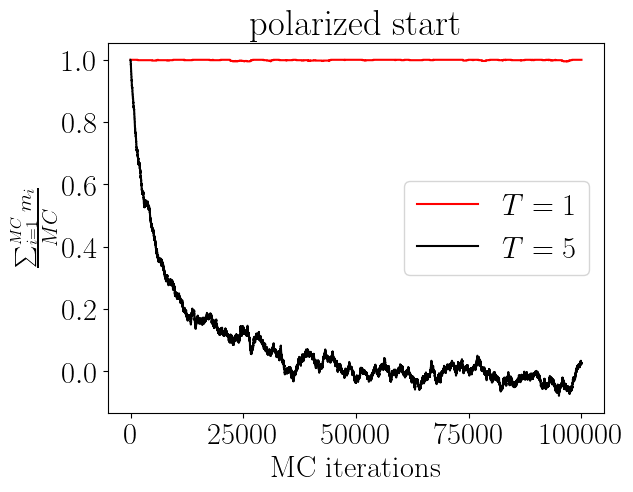

In [582]:
energy_arr_T1, mz_arr_T1 = return_mc2D(N=40,T=1,ITER=100000,include_warm=True,start='up')
energy_arr_T5, mz_arr_T5 = return_mc2D(N=40,T=5,ITER=100000,include_warm=True,start='up')

plt.plot(mz_arr_T1,label=r'$T=1$',color='red')
plt.plot(mz_arr_T5,label=r'$T=5$',color='black')
plt.xlabel('MC iterations')
plt.ylabel(r'$\frac{\sum_{i=1}^{MC}m_i}{MC}$')
plt.title('polarized start')
plt.legend()

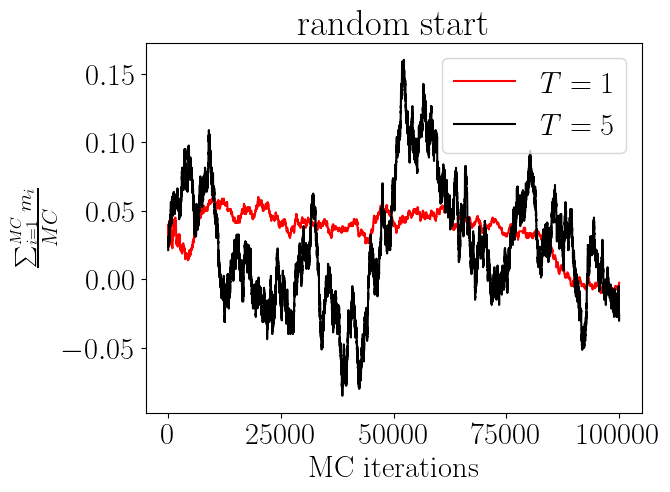

In [583]:
energy_arr_T1, mz_arr_T1 = return_mc2D(N=40,T=1,ITER=100000,include_warm=True,start='random')
energy_arr_T5, mz_arr_T5 = return_mc2D(N=40,T=5,ITER=100000,include_warm=True,start='random')

plt.plot(mz_arr_T1,label=r'$T=1$',color='red')
plt.plot(mz_arr_T5,label=r'$T=5$',color='black')
plt.xlabel('MC iterations')
plt.ylabel(r'$\frac{\sum_{i=1}^{MC}m_i}{MC}$')
plt.title('random start')
plt.legend()

# Ex.2.

In [587]:
energy_arr_T1, mz_arr_T1 = return_mc2D(N=40,T=1,ITER=100000,include_warm=False,start='random')
energy_arr_T2, mz_arr_T2 = return_mc2D(N=40,T=2,ITER=100000,include_warm=False,start='random')
energy_arr_T5, mz_arr_T5 = return_mc2D(N=40,T=5,ITER=100000,include_warm=False,start='random')

100%|██████████| 93398/93398 [08:08<00:00, 191.34it/s]


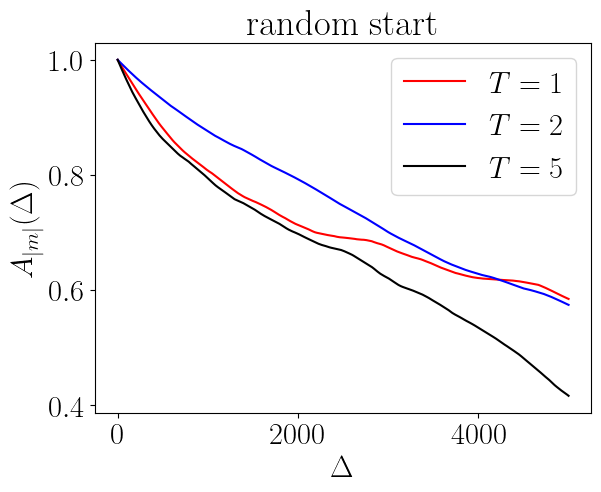

In [588]:
plt.plot(compute_autocorr(np.abs(mz_arr_T1),DeltaRange=5000),label=r'$T=1$',color='red')
plt.plot(compute_autocorr(np.abs(mz_arr_T2),DeltaRange=5000),label=r'$T=2$',color='blue')
plt.plot(compute_autocorr(np.abs(mz_arr_T5),DeltaRange=5000),label=r'$T=5$',color='black')
plt.xlabel(r'$\Delta$')
plt.ylabel(r'$A_{|m|}(\Delta)$')
plt.title('random start')
plt.legend()

### plotting $T=5$ for longer $\Delta$, as takes a lot of time

  0%|          | 0/88398 [00:00<?, ?it/s]

100%|██████████| 88398/88398 [14:42<00:00, 100.17it/s]


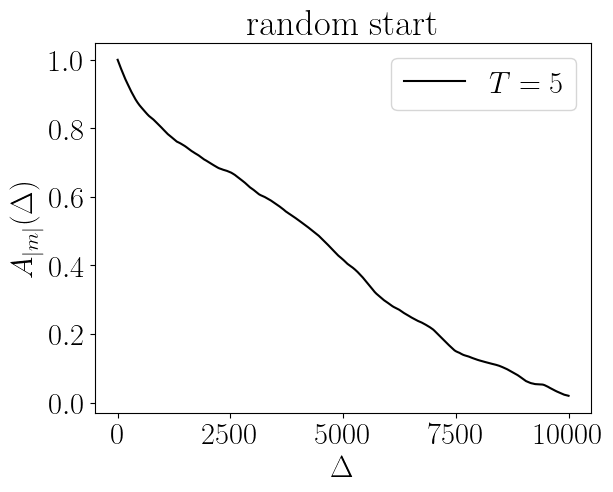

In [637]:
plt.plot(compute_autocorr(np.abs(mz_arr_T5),DeltaRange=10000),label=r'$T=5$',color='black')
plt.xlabel(r'$\Delta$')
plt.ylabel(r'$A_{|m|}(\Delta)$')
plt.title('random start')
plt.legend()

# Ex.3.

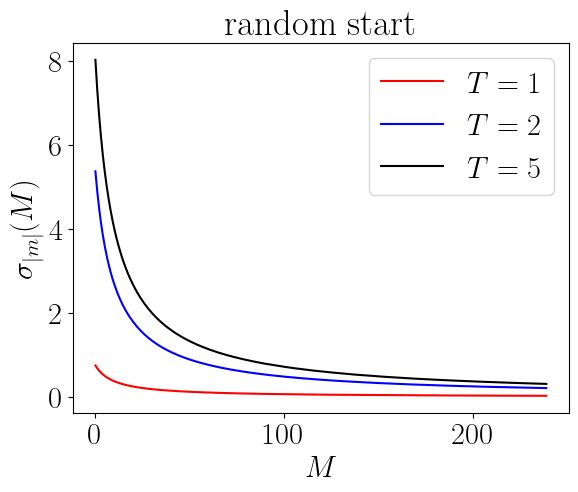

In [619]:
plt.plot(binning_error_plot(np.abs(mz_arr_T1),MRange=250),label=r'$T=1$',color='red')
plt.plot(binning_error_plot(np.abs(mz_arr_T2),MRange=250),label=r'$T=2$',color='blue')
plt.plot(binning_error_plot(np.abs(mz_arr_T5),MRange=250),label=r'$T=5$',color='black')
plt.xlabel(r'$M$')
plt.ylabel(r'$\sigma_{|m|}(M)$')
plt.title('random start')
plt.legend()

Text(0, 0.5, '$(Q_b - \\bar{Q})^2$')

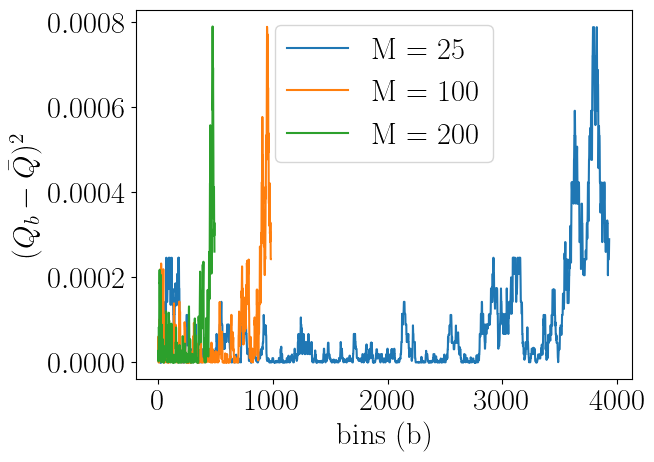

In [620]:
# plot of the binning fluctuations for different values of M (B) 


M = 25
q_arr = np.abs(mz_arr_T1)
POSTINIT = len(q_arr)
B = int((POSTINIT) / M)
Qbavs = [np.sum(q_arr[b * M: (b+1) * M]) / M for b in range(B)]
Qav = np.sum(Qbavs) / B 
plt.plot((Qbavs - Qav) ** 2, label='M = ' + str(M))


M = 100
q_arr = np.abs(mz_arr_T1)
POSTINIT = len(q_arr)
B = int((POSTINIT) / M)
Qbavs = [np.sum(q_arr[b * M: (b+1) * M]) / M for b in range(B)]
Qav = np.sum(Qbavs) / B 
plt.plot((Qbavs - Qav) ** 2, label='M = ' + str(M))


M = 200
q_arr = np.abs(mz_arr_T1)
POSTINIT = len(q_arr)
B = int((POSTINIT) / M)
Qbavs = [np.sum(q_arr[b * M: (b+1) * M]) / M for b in range(B)]
Qav = np.sum(Qbavs) / B 
plt.plot((Qbavs - Qav) ** 2, label='M = ' + str(M))


plt.legend()
plt.xlabel('bins (b)')
plt.ylabel(r'$(Q_b - \bar{Q})^2$')

# Ex.4.

In [670]:
from joblib import Parallel, delayed #need parallel processing for averaging "quickly" over 10 MC runs for smoothness of curves

def compute_marr(L=40,Temp_arr= np.linspace(1,5,20),REPEAT=10):
    m_arr = np.zeros(len(Temp_arr))
    for ii, T in tqdm(enumerate(Temp_arr)):
        def get_mz(iii): # iii is dummy input
            #function to feed into the parallel solver
            _, mzarr = return_mc2D(N=L,T=T,ITER=50000 + L**2,include_warm=False,start='up')
            return mzarr

        POSTINIT = 50000-1 # post-warmup steps
        mz_arr_av = np.zeros(POSTINIT) 
        
        out = Parallel(n_jobs=10, verbose=100)(delayed(get_mz)(i) for i in range(REPEAT)) #parallel solver
        mz_arr_av = np.sum(out,axis=0)
        mz_arr_av = mz_arr_av / REPEAT #averaged
        
        SKIP = 1 #if you want to skip between the sampled steps, here i am not (can do L**2 skipping later)
        sample_arr = [mz_arr_av[jj * SKIP] for jj in range(int(POSTINIT/(SKIP))-1)]
        m_arr[ii] = (np.sum(np.abs(sample_arr))/len(sample_arr)) # compute <|m|> at T = T[ii]

    return m_arr 


T_arr = np.linspace(1,4,20) #temp_Array

m_arr_L10 = compute_marr(L=10,Temp_arr=T_arr)
print('L = 10 done') 

m_arr_L20 = compute_marr(L=20,Temp_arr=T_arr)
print('L = 20 done') 



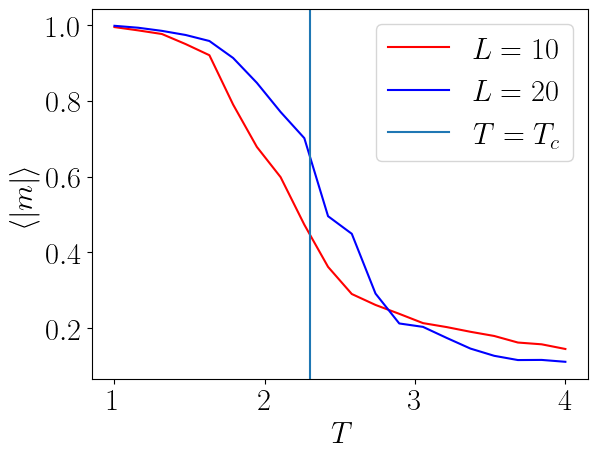

In [671]:
plt.plot(T_arr,m_arr_L10,label=r'$L=10$',color='red')
plt.plot(T_arr,m_arr_L20,label=r'$L=20$',color='blue')
plt.axvline(x=2.3,label=r'$T = T_c$')
plt.xlabel(r'$T$')
plt.ylabel(r'$\langle|m|\rangle$')
plt.legend()

In [6]:
def return_mc2D(N=15,T=0.1,ITER=50000,include_warm=False,start='up'):
    INIT_TIME = 1e4

    # check if warmup results are to be included or not 
    if include_warm == True:
        INIT_TIME = 0

    #different methods to start in
    if start == 'up':
        config = np.ones((N,N)) 
    elif start == 'down':
        config = -np.ones((N,N)) 
    elif start == 'random':
        config = np.random.choice([1,-1],size=(N,N))
    elif start == 'rowneel':
        config = np.ones((N,N))  
        for i in range(N):
            if i %2 == 0:
                config[i,:] = -1
    elif start == 'columnneel':
        config = np.ones((N,N))  
        for i in range(N):
            if i %2 == 0:
                config[:,i] = -1

    # returning arrays
    mz_arr = []
    energy_arr = []
    
    # main loop
    for idx in tqdm(range(ITER)):
        energy = compute_energy2D(config) 
        
        if idx > INIT_TIME:
            energy_arr.append(energy)
            mz = (np.sum(config)) / (N**2)
            mz_arr.append(mz)

        # choose random site coordinates
        row_ind = random.choice(range(N))
        column_ind = random.choice(range(N)) 

        newconfig = np.copy(config) 
        newconfig[row_ind,column_ind] = -config[row_ind,column_ind] # flip random site

        newenergy = compute_energy2D(newconfig)
        if newenergy < energy:  # case 1
            config = np.copy(newconfig) 
        
        elif newenergy > energy: # case 2 
            delta = - energy + newenergy
            prob = np.exp(-delta / (k * T))
        
            u = np.random.uniform()
            if u < prob: # sub-case
                config = np.copy(newconfig) 

    return np.array(energy_arr), np.array(mz_arr)


def compute_marr(L=40,Temp_arr= np.linspace(1,5,20),REPEAT=1):
    m_arr = np.zeros(len(Temp_arr))
    POSTINIT = int(1e6 - 1e4 - 1)
    def get_mz(T): # iii is dummy input
        #function to feed into the parallel solver
        _, mzarr = return_mc2D(N=L,T=T,ITER=int(1e6),include_warm=False,start='up')
        SKIP = 1 #if you want to skip between the sampled steps, here i am not (can do L**2 skipping later)
        sample_arr = [mzarr[jj * SKIP] for jj in range(int(POSTINIT/(SKIP))-1)]
        return (np.sum(np.abs(sample_arr))/len(sample_arr)) # compute <|m|> at T = T[ii]
    out = Parallel(n_jobs=20, verbose=100)(delayed(get_mz)(T) for T in Temp_arr) #parallel solver
    return out 


T_arr = np.linspace(1,4,20) #temp_Array

m_arr_L100 = compute_marr(L=100,Temp_arr=T_arr)



[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


  4%|▍         | 41663/1000000 [05:00<2:35:24, 102.78it/s]/Users/siddhantm/miniconda3/envs/qt/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 98%|█████████▊| 982623/1000000 [3:46:53<04:58, 58.29it/s]

[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed: 226.9min


 98%|█████████▊| 983291/1000000 [3:48:02<05:01, 55.47it/s]

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed: 228.1min remaining: 2052.7min


 97%|█████████▋| 973841/1000000 [3:48:05<07:03, 61.77it/s]

[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed: 228.1min remaining: 1292.7min


 96%|█████████▌| 962204/1000000 [3:49:35<07:37, 82.63it/s] 

[Parallel(n_jobs=20)]: Done   4 out of  20 | elapsed: 229.6min remaining: 918.5min


 96%|█████████▋| 964203/1000000 [3:50:02<08:19, 71.63it/s]

[Parallel(n_jobs=20)]: Done   5 out of  20 | elapsed: 230.1min remaining: 690.2min


 98%|█████████▊| 975506/1000000 [3:50:02<04:38, 87.80it/s]

[Parallel(n_jobs=20)]: Done   6 out of  20 | elapsed: 230.1min remaining: 536.9min


 99%|█████████▉| 990028/1000000 [3:50:30<01:58, 84.30it/s]

[Parallel(n_jobs=20)]: Done   7 out of  20 | elapsed: 230.5min remaining: 428.1min


 99%|█████████▉| 992295/1000000 [3:50:55<01:22, 93.56it/s]]

[Parallel(n_jobs=20)]: Done   8 out of  20 | elapsed: 231.0min remaining: 346.4min


 95%|█████████▌| 951476/1000000 [3:46:04<08:35, 94.20it/s]]

[Parallel(n_jobs=20)]: Done   9 out of  20 | elapsed: 231.2min remaining: 282.5min


 97%|█████████▋| 972337/1000000 [3:51:29<04:20, 106.23it/s]

[Parallel(n_jobs=20)]: Done  10 out of  20 | elapsed: 231.5min remaining: 231.5min


 97%|█████████▋| 965843/1000000 [3:47:03<06:11, 91.85it/s] 

[Parallel(n_jobs=20)]: Done  11 out of  20 | elapsed: 232.1min remaining: 189.9min


 97%|█████████▋| 971821/1000000 [3:47:48<03:35, 130.79it/s]

[Parallel(n_jobs=20)]: Done  12 out of  20 | elapsed: 232.9min remaining: 155.3min


100%|█████████▉| 997389/1000000 [3:53:16<00:16, 158.29it/s]

[Parallel(n_jobs=20)]: Done  13 out of  20 | elapsed: 233.3min remaining: 125.6min


100%|█████████▉| 995409/1000000 [3:53:17<00:26, 173.16it/s]

[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed: 233.3min remaining: 100.0min


 98%|█████████▊| 979028/1000000 [3:48:30<01:37, 215.95it/s]

[Parallel(n_jobs=20)]: Done  15 out of  20 | elapsed: 233.6min remaining: 77.9min


 98%|█████████▊| 981080/1000000 [3:48:39<01:30, 209.03it/s]

[Parallel(n_jobs=20)]: Done  16 out of  20 | elapsed: 233.7min remaining: 58.4min


 98%|█████████▊| 982041/1000000 [3:49:10<01:07, 265.72it/s]

[Parallel(n_jobs=20)]: Done  17 out of  20 | elapsed: 234.3min remaining: 41.3min


 98%|█████████▊| 982098/1000000 [3:49:11<01:05, 273.16it/s]

[Parallel(n_jobs=20)]: Done  18 out of  20 | elapsed: 234.3min remaining: 26.0min


100%|██████████| 1000000/1000000 [3:49:51<00:00, 72.51it/s]


[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed: 235.0min finished
